# CSC 21700 Final Project

## Intro

For this project I am taking a look at gun data from [Enigma Public](https://public.enigma.com/datasets/d4f09262-4ce1-404b-9d8a-1b84ef22d362). More specifically, I will be taking a look the rates of lost/stolen/recovered guns as reported by law enforcement between states, status, offense that lead to the gun, gun type, and year. By looking at each variable independently, I will hope to answer questions such as which state had the highest rate of guns reported? What status most frequently? What was the trend betwee the years? What offenses showed up the most? And What was the most frequent gun type? I will also be taking a look at pair-wise relationships between the variables to answer questions such what states had the highest number of reporting each year? What were the most common gun types in the top states?

Population was also taken into consideration so population data from the 2010 census was used to determine the number of guns reported per 100,000 people to compensate for differences in reporting from agencies. In the Enigma Public dataset, data prior to 2010 and after 2016 was removed since it is noticeably incomplete from the data from 2010 to 2016.

The term 'reported' will be used in place of lost/stolen/recovered for simplicty

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

## Dataset

In [2]:
df = pd.read_csv('475633aa-9ea6-4b01-a567-ed3e93d32301_MissingPiecesData.csv')
#Reduce columns, remove rows with NaN
df = df.filter(['state', 'location', 'status', 'year', 'offense', 'gun_type'], axis=1).dropna()
#converts 'year' from a float to an integer
df = df.astype({'year': 'int32'})
#Removes 2017 and years before 2010
df = df[(df['year'] > 2009) & (df['year'] < 2017)]
df = df.reset_index()
df = df.drop(columns='index')
df = df.rename({'gun_type': 'gun type'}, axis=1)
df

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (13,16,17,18,19,20,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,state,location,status,year,offense,gun type
0,AZ,CHANDLER,RECOVERED,2013,ASLT AGG WEAPO,RIFLE
1,AZ,CHANDLER,RECOVERED,2013,INTIMIDATION,RIFLE
2,AZ,CHANDLER,RECOVERED,2013,WEAPONS,RIFLE
3,AZ,CHANDLER,RECOVERED,2013,OBST JUDICIAL,RIFLE
4,AZ,CHANDLER,RECOVERED,2013,ASLT AGG WEAPO,RIFLE
5,AZ,CHANDLER,RECOVERED,2013,INTIMIDATION,RIFLE
6,AZ,CHANDLER,RECOVERED,2013,WEAPONS,RIFLE
7,AZ,CHANDLER,RECOVERED,2013,OBST JUDICIAL,RIFLE
8,AZ,CHANDLER,RECOVERED,2013,ASLT AGG WEAPO,PISTOL
9,AZ,CHANDLER,RECOVERED,2013,INTIMIDATION,PISTOL


### Definitions
* LOST: Indicates a firearm that was reported lost.
* LOST/STOLEN: Indicates a firearm that was reported lost or stolen. (Some agencies do not differentiate.)
* STOLEN: Indicates a firearm that was reported stolen.
* STOLEN (RECOVERED): Indicates a firearm that was reported stolen, where the record notes – either in the `agency_status` column or elsewhere – that the firearm was later recovered.
* RECOVERED: Indicates a firearm that was seized or otherwise recovered by an agency.
* RECOVERED (STOLEN): Indicates a firearm that was seized or otherwise recovered by an agency, where the record notes that the firearm was originally stolen.

## Visualizations And Single Variable Explorations

In [3]:
def get_guns_per1(three_group_df, one_group_df):
    result_list = []
    key = three_group_df.columns[-2]
    val_list = one_group_df[key]
    
    for val in val_list:
        loc_pop_sum, result = 0, 0
        locations = three_group_df[three_group_df[key] == val]['location']
        count_sum = three_group_df[three_group_df[key] == val]['count'].sum()
        for location in locations:
            loc_pop = np.array(state_location[state_location['location'] == location]['population'])[0]
            loc_pop_sum = loc_pop_sum + loc_pop
        result = ((count_sum / loc_pop_sum) * 100000).round()
        result_list.append(result)
    
    return result_list

In [4]:
# numbers the graphs
global fig_num
fig_num = 0

In [5]:
# Scrapes the abbreviations of US state names into a dataframe to later be put into a dictionary
state_abbr = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations')
state_abbr = state_abbr[0]
column_names = []

for i in range(len(state_abbr.columns)):
    column_names.append(str(i))

state_abbr.columns = column_names
state_abbr = state_abbr.filter(['0', '3'], axis=1).rename({'0': 'state', '3': 'abbr'}, axis=1)
state_abbr = state_abbr.dropna().reset_index().drop('index', axis=1)
state_abbr = state_abbr[2:53].reset_index().drop('index', axis=1)

In [6]:
# Turns the previous dataframe into a dictionary
name_abbr = {}
for i in range(len(state_abbr)):
    name_abbr[state_abbr.iloc[i, 1]] = state_abbr.iloc[i, 0]

In [7]:
# Dataframe for populations of towns, cities, counties, etc
state_location = pd.DataFrame()
state_location['count'] = df.groupby('state')['location'].value_counts()
state_location = state_location.reset_index()

In [8]:
# fetches populations of town towns, cities, counties, etc from wikipedia and 2010 census data
pop = []
for i in range(len(state_location)):
    if 'ELK TWP' in state_location.iloc[i, 1]:
        url_df = pd.read_html('https://en.wikipedia.org/wiki/Elk_Township,_New_Jersey')
        url_df = url_df[1]
        pop.append(int(url_df.iloc[11, 1]))
    elif 'MEDFORD LAKES' in state_location.iloc[i, 1]:
        url_df = pd.read_html('https://en.wikipedia.org/wiki/Medford_Lakes,_New_Jersey')
        url_df = url_df[2]
        pop.append(int(url_df.iloc[7, 1]))
    elif 'TOWN' in state_location.iloc[i, 1] or 'COUNTY' in state_location.iloc[i, 1] or 'VILLAGE' in state_location.iloc[i, 1]:
        city = state_location.iloc[i,1]
        city = city.lower()
        city = city.replace(' ', '')
        state = name_abbr[state_location.iloc[i,0]]
        state = state.lower()
        state = state.replace(' ', '')
        url = 'https://www.census.gov/quickfacts/fact/table/' + city + state + '/POP010210'
        url_df = pd.read_html(url)
        pop.append(int(url_df[0].iloc[0,1]))
    else:
        city = state_location.iloc[i,1] + 'city'
        city = city.lower()
        city = city.replace(' ', '')
        state = name_abbr[state_location.iloc[i,0]]
        state = state.lower()
        state = state.replace(' ', '')
        url = 'https://www.census.gov/quickfacts/fact/table/' + city + state + '/POP010210'
        url_df = pd.read_html(url)
        pop.append(int(url_df[0].iloc[0,1]))
        
state_location['population'] = pop
state_location['guns per 100,000 people'] = ((state_location['count'] / state_location['population']) * 100000).round()
state_location = state_location.astype({'guns per 100,000 people': 'int32'})
state_location = state_location.sort_values('guns per 100,000 people', ascending=False)

## Year

In [9]:
year_df = df.groupby('year').size().reset_index()
year_df = year_df.rename({0: 'count'}, axis=1)
total_pop = state_location['population'].sum()
year_df['guns per 100,000 people'] = (year_df['count'] / total_pop * 100000).round()
year_df = year_df.astype({'guns per 100,000 people': 'int32'})
year_df

,year,count,"guns per 100,000 people"
0,2010,24065,105
1,2011,23318,102
2,2012,24326,106
3,2013,25052,110
4,2014,22301,98
5,2015,25316,111
6,2016,24050,105


In [10]:
#year of highest guns per 100,000 people
year_df[year_df['guns per 100,000 people'] == year_df['guns per 100,000 people'].max()]

,year,count,"guns per 100,000 people"
5,2015,25316,111


In [11]:
#year of lowest guns per 100,000 people
year_df[year_df['guns per 100,000 people'] == year_df['guns per 100,000 people'].min()]

,year,count,"guns per 100,000 people"
4,2014,22301,98


In [12]:
print('Mean:', year_df['guns per 100,000 people'].mean())
print('Median:', year_df['guns per 100,000 people'].median())
print('Standard deviation:', year_df['guns per 100,000 people'].std())

Mean: 105.28571428571429
Median: 105.0
Standard deviation: 4.46147530585589


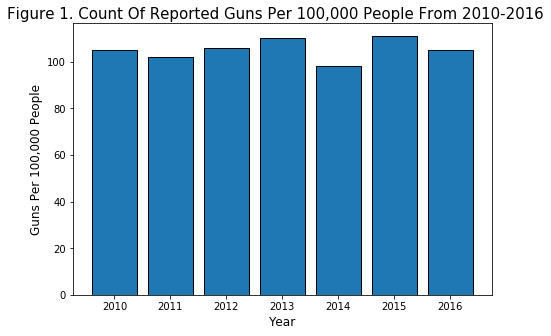

In [13]:
fig = plt.figure(figsize=(7.5,5))
plt.bar(year_df['year'], year_df['guns per 100,000 people'], edgecolor='black')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Guns Per 100,000 People', fontsize=12)
fig_num = fig_num + 1
fig.suptitle('Figure {}. Count Of Reported Guns Per 100,000 People From 2010-2016'.format(fig_num), fontsize=15, y=0.925)
plt.show()

From 2010 to 2016, the rate of guns reported had a uniform distribution with 2015 having the highest rate at 111 guns per 100,000 people and 2014 having the lowest rate at 98 guns per 100,000 people. With the mean and median being similar to each other at 105.28571428571429 and 105 respectively, and a relatively low standard deviation at 4.46147530585589, it further supports the statement of the the distribution being uniform.

## State

In [14]:
state_df = df['state'].value_counts().reset_index()
state_df = state_df.rename({'index': 'state', 'state': 'count'}, axis=1)

state_pop, per10000 = [], []
for state in state_df['state']:
    pop_sum = state_location[state_location['state'] == state]['population'].sum()
    state_pop.append(pop_sum)
    
state_df['population'] = state_pop
state_df['guns per 100,000 people'] = ((state_df['count'] / state_df['population']) * 100000).round()
state_df = state_df.astype({'guns per 100,000 people': 'int32'})
state_df = state_df.sort_values('guns per 100,000 people', ascending=False)

In [15]:
state_df

,state,count,population,"guns per 100,000 people"
3,MO,16016,319294,5016
1,MD,29808,620961,4800
6,NY,6515,210565,3094
10,KS,1607,127473,1261
9,AZ,2829,236123,1198
4,WA,14523,1259405,1153
5,CO,12671,1366839,927
0,TX,43147,4939812,873
2,CA,29558,3637739,813
7,OR,4244,583776,727


In [16]:
print('Mean:', state_df['guns per 100,000 people'].mean())
print('Median:', state_df['guns per 100,000 people'].median())
print('Standard deviation:', state_df['guns per 100,000 people'].std())

Mean: 1257.4117647058824
Median: 813.0
Standard deviation: 1554.766423728317


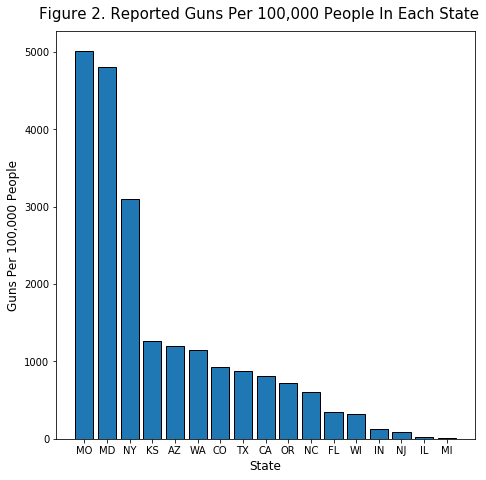

In [17]:
fig = plt.figure(figsize=(7.5,7.5))
plt.bar(x=state_df['state'], height=state_df['guns per 100,000 people'], edgecolor='black')
plt.xlabel('State', fontsize=12)
plt.ylabel('Guns Per 100,000 People', fontsize=12)
fig_num = fig_num + 1
fig.suptitle('Figure {}. Reported Guns Per 100,000 People In Each State'.format(fig_num), fontsize=15, y=0.925)
plt.show()

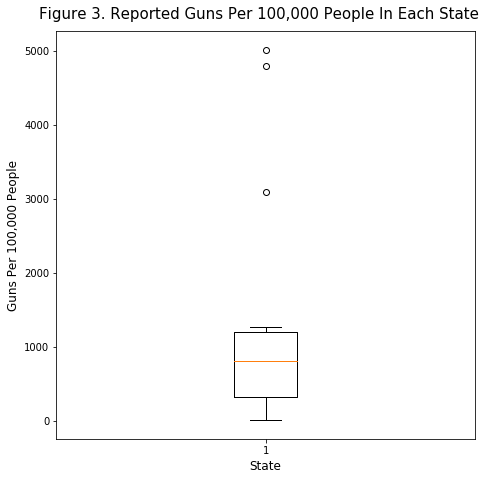

In [18]:
fig = plt.figure(figsize=(7.5,7.5))
plt.boxplot(state_df['guns per 100,000 people'])
plt.xlabel('State', fontsize=12)
plt.ylabel('Guns Per 100,000 People', fontsize=12)
fig_num = fig_num + 1
fig.suptitle('Figure {}. Reported Guns Per 100,000 People In Each State'.format(fig_num), fontsize=15, y=0.925)
plt.show()

In [19]:
# upper cutoff
state_df['guns per 100,000 people'].quantile(0.75) + (1.5 * (state_df['guns per 100,000 people'].quantile(0.75) - state_df['guns per 100,000 people'].quantile(0.25)))

2510.5

In [20]:
state_df[state_df['guns per 100,000 people'] > 2510.5]

,state,count,population,"guns per 100,000 people"
3,MO,16016,319294,5016
1,MD,29808,620961,4800
6,NY,6515,210565,3094


When broken down by states, the mean number of reported guns per 100,000 people is 1257.4117647058824 while the median is 813. It is visible from the bar chart that Missouri, Maryland, and New York are skewing the mean and they are potentional outliers. To formally prove there are outliers, a boxplot is used and it can be seen from the boxplot that there are three outliers. When calculating the formal upper cutoff and filter out the rows that are below the cutoff, it is confirmed that Missouri, Maryland, and New York are the outliers. 

## Status

In [21]:
result_list = []
status_df = df['status'].value_counts().reset_index()
status_df = status_df.rename({'index': 'status', 'status': 'count'}, axis=1)
state_location_status = df.groupby(['state', 'location', 'status']).size().reset_index().rename({0: 'count'}, axis=1)
status_list = status_df['status']
status_df['guns per 100,000 people'] = get_guns_per1(state_location_status, status_df)
status_df = status_df.astype({'guns per 100,000 people': 'int32'})
status_df = status_df.sort_values('guns per 100,000 people', ascending=False)
status_df

,status,count,"guns per 100,000 people"
0,RECOVERED,133253,711
2,LOST/STOLEN,8789,514
1,STOLEN,21198,230
3,RECOVERED (STOLEN),4026,63
4,STOLEN (RECOVERED),792,29
5,LOST,370,10


In [22]:
print('Mean:', status_df['guns per 100,000 people'].mean())
print('Median:', status_df['guns per 100,000 people'].median())
print('Standard deviation:', status_df['guns per 100,000 people'].std())

Mean: 259.5
Median: 146.5
Standard deviation: 291.02766191549557


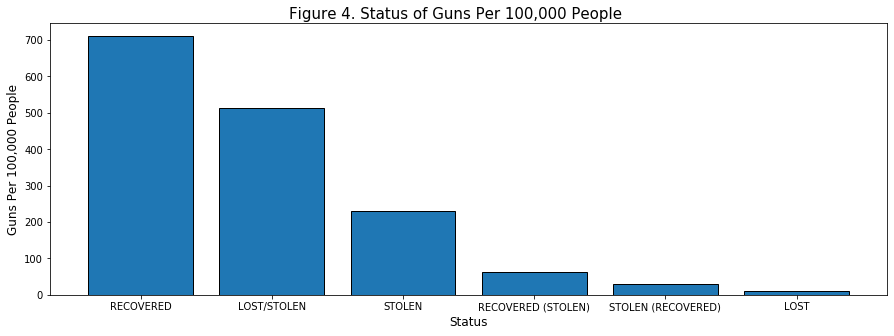

In [23]:
fig = plt.figure(figsize=(15,5))
plt.bar(status_df['status'], status_df['guns per 100,000 people'], edgecolor='black')
plt.xlabel('Status', fontsize=12)
plt.ylabel('Guns Per 100,000 People', fontsize=12)
fig_num = fig_num + 1
fig.suptitle('Figure {}. Status of Guns Per 100,000 People'.format(fig_num), fontsize=15, y=0.925)
plt.show()

When looking at the guns per 100,000 people by status, most of the guns have been recovered, While the least amount has been reported lost

## Gun Type

In [24]:
gun_df = df['gun type'].value_counts().reset_index()
gun_df = gun_df.rename({'index': 'gun type', 'gun type': 'count'}, axis=1)
state_location_gun = df.groupby(['state', 'location', 'gun type']).size().reset_index().rename({0: 'count'}, axis=1)
gun_list = gun_df['gun type']
gun_df['guns per 100,000 people'] = get_guns_per1(state_location_gun, gun_df)
gun_df = gun_df.astype({'guns per 100,000 people': 'int32'})
gun_df = gun_df.sort_values('guns per 100,000 people', ascending=False)
gun_df

,gun type,count,"guns per 100,000 people"
0,PISTOL,116196,512
12,LONG GUN,5,119
1,RIFLE,25418,119
2,SHOTGUN,20546,94
15,REVOLVER,3,72
3,ALL OTHERS,3390,34
4,RIFLE SHOTGUN COMBINATION,1630,17
5,AMMUNITION,892,15
13,BOMB,4,2
8,SHOTGUN PISTOL,78,2


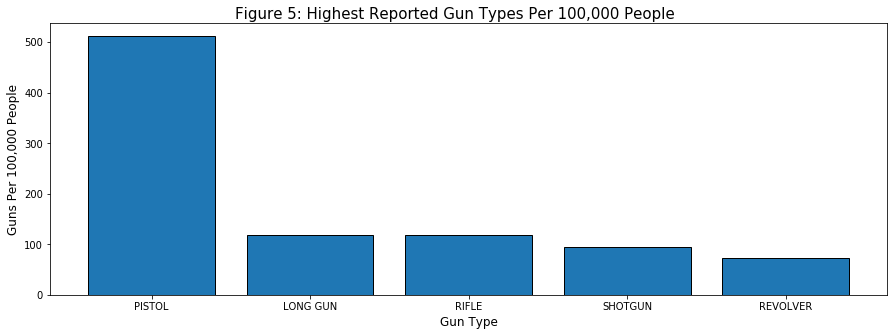

In [25]:
fig = plt.figure(figsize=(15,5))
plt.bar(gun_df.head()['gun type'], gun_df.head()['guns per 100,000 people'], edgecolor='black')
plt.xlabel('Gun Type', fontsize=12)
plt.ylabel('Guns Per 100,000 People', fontsize=12)
fig_num = fig_num + 1
fig.suptitle('Figure {}: Highest Reported Gun Types Per 100,000 People'.format(fig_num), fontsize=15, y=0.925)
plt.show()

Pistols in total had the highest rate of being reported at 512 pistols per 100,000 people. The next highest guns were long guns, rifles, shotguns, and revolvers were reported at a much lower rate compared to pistols. Long guns started at a rate of 119 guns per 100,000 people.  

## Offense

In [26]:
result_list = []
offense_df = df['offense'].value_counts().reset_index()
offense_df = offense_df.rename({'index': 'offense', 'offense': 'count'}, axis=1)
state_location_offense = df.groupby(['state', 'location', 'offense']).size().reset_index().rename({0: 'count'}, axis=1)
offense_list = offense_df['offense'] 
offense_df['guns per 100,000 people'] = get_guns_per1(state_location_offense, offense_df)
offense_df = offense_df.astype({'guns per 100,000 people': 'int32'})
offense_df = offense_df.sort_values('guns per 100,000 people', ascending=False)
offense_df

,offense,count,"guns per 100,000 people"
0,HANDGUN VIOLATION,12427,2001
21,CRIMINAL POSSESSION OF A WEAPON,1351,642
28,DESTROY,1003,476
20,BURGLARY SECOND DEGREE,1387,434
10,MISCELLANEOUS SAFEKEEPING,2665,429
11,CONTROLLED DANGEROUS SUBSTANCE,2538,409
23,STOLEN PROPERTY OFFENSES,1255,393
26,FELONY UNLAWFUL USE OF WEAPON,1055,330
46,EVIDENCE INVESTIGATION,691,328
2,RECOVERED FOUND PROPERTY,5904,306


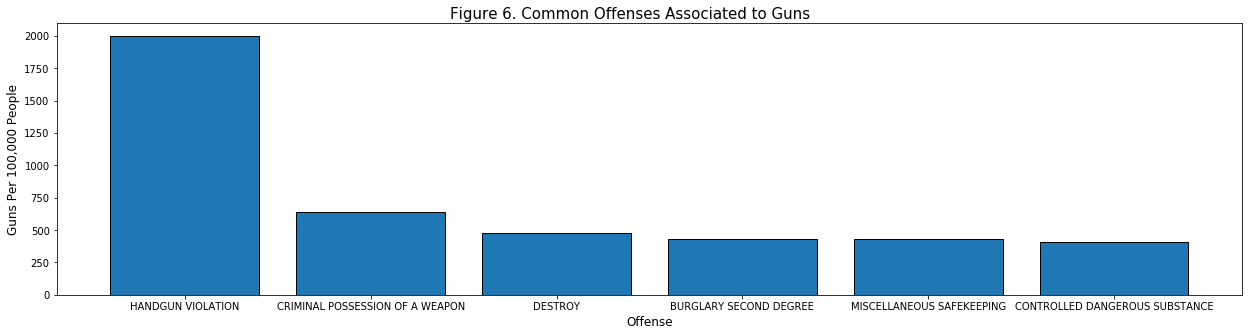

In [27]:
fig = plt.figure(figsize=(21.25, 5))
plt.bar(offense_df.head(6)['offense'], offense_df.head(6)['guns per 100,000 people'], edgecolor='black')
plt.xlabel('Offense', fontsize=12)
plt.ylabel('Guns Per 100,000 People', fontsize=12)
fig_num = fig_num + 1
fig.suptitle('Figure {}. Common Offenses Associated to Guns'.format(fig_num), fontsize=15, y=0.925)
plt.show()

Handgun violations had the highest rate of being associated to a weapon offense at a rate of 2001 guns per 100,000 people. The procceding offenses drastically reduce in rate with the next highest offense being criminal possession of a weapon at 642 guns per 100,000 people. As seen in the previous figure, pistols had the highest rate of being reported, so it is no surprise that handgun violations had the highest rate of offenses reported. 

## Pair-Wise Explorations

In [28]:
#def get_guns_per2(three_group_df, two_group_df)
def get_guns_per2(three_group_df, two_group_df):
    result_list = []
    key1, key2 = three_group_df.columns[0], three_group_df.columns[1]
    for i in range(len(two_group_df)):
        locations = three_group_df[(three_group_df[key1] == two_group_df.iloc[i, 0]) & (three_group_df[key2] == two_group_df.iloc[i, 1])]['location']
        loc_pop_sum = 0
        for location in locations:
            loc_pop = state_location[state_location['location'] == location]['population'].to_list()[0]
            loc_pop_sum = loc_pop_sum + loc_pop
        count_sum = two_group_df.iloc[i,2]
        result = ((count_sum / loc_pop_sum) * 100000).round()
        result_list.append(result)
    return result_list

In [29]:
def show_grouped_bar(df, title, size=(10,10)):
    fig = plt.figure(figsize=size)
    labels = df.columns.to_list()[1:]
    bar_width = 1/(len(labels) + 1)

    # creates matrix of bar heights. Takes a column from the dataframe and turns it into a row in the matrix
    bar_heights = []
    for val in labels:
        bar_heights.append(df[val].to_list())
    
    # creates matrix of x-positions for the bars
    bar_pos = []
    bar_pos.append(np.arange(len(bar_heights[0])))
    for i in range(1, len(bar_heights)):
        bar_pos.append([x + bar_width for x in bar_pos[i - 1]])
    
    # plots the bars
    for i in range(len(bar_heights)):
        plt.bar(bar_pos[i], bar_heights[i], width=bar_width, edgecolor='black', label=labels[i])

    # If there are an odd number of groups, then the positions of the middle bars are chosen
    # else, the positions between the two middle bars are found
    if len(bar_pos) % 2:
        mid = bar_pos[int(len(bar_pos)/2)]
    else:
        mid_left = np.asarray(bar_pos[int(len(bar_pos)/2) - 1])
        mid_right = np.asarray(bar_pos[int(len(bar_pos)/2)])
        mid = (mid_left + mid_right) / 2
        
    x_ticks = df.iloc[:,0].to_list()
    plt.xticks(mid, x_ticks)
    plt.xlabel(df.columns.to_list()[0].capitalize(), fontsize=12)
    plt.ylabel('Guns Per 100,000 People', fontsize=12)
    global fig_num
    fig_num = fig_num + 1
    title = 'Figure {}. '.format(fig_num) + title
    fig.suptitle(title, fontsize=15, y=0.925)
    plt.legend()
    plt.show()

## Year and Status

In [30]:
year_status = pd.DataFrame()
year_status['count'] = df.groupby('year')['status'].value_counts()
year_status = year_status.reset_index()
year_status_location = df.groupby(['year', 'status', 'location']).size().reset_index().rename({0: 'count'}, axis=1)
year_status['guns per 100,000 people'] = get_guns_per2(year_status_location, year_status)
year_status = year_status.astype({'guns per 100,000 people': 'int32'})

In [31]:
year_status_per = pd.DataFrame()
year_status_per['year'] = year_status['year'].unique()
status_list = ['RECOVERED','LOST/STOLEN','STOLEN','RECOVERED (STOLEN)','STOLEN (RECOVERED)','LOST']

for status in status_list:
    year_status_per[status] = year_status[year_status['status'] == status]['guns per 100,000 people'].to_list()

year_status_per

,year,RECOVERED,LOST/STOLEN,STOLEN,RECOVERED (STOLEN),STOLEN (RECOVERED),LOST
0,2010,112,79,39,11,5,3
1,2011,109,78,39,9,5,1
2,2012,114,73,38,9,7,2
3,2013,120,89,35,9,11,3
4,2014,99,92,38,11,6,2
5,2015,107,100,40,13,9,2
6,2016,100,72,44,19,8,1


In [32]:
year_status_per['RECOVERED'].mean()

108.71428571428571

In [33]:
year_status_per['LOST'].mean()

2.0

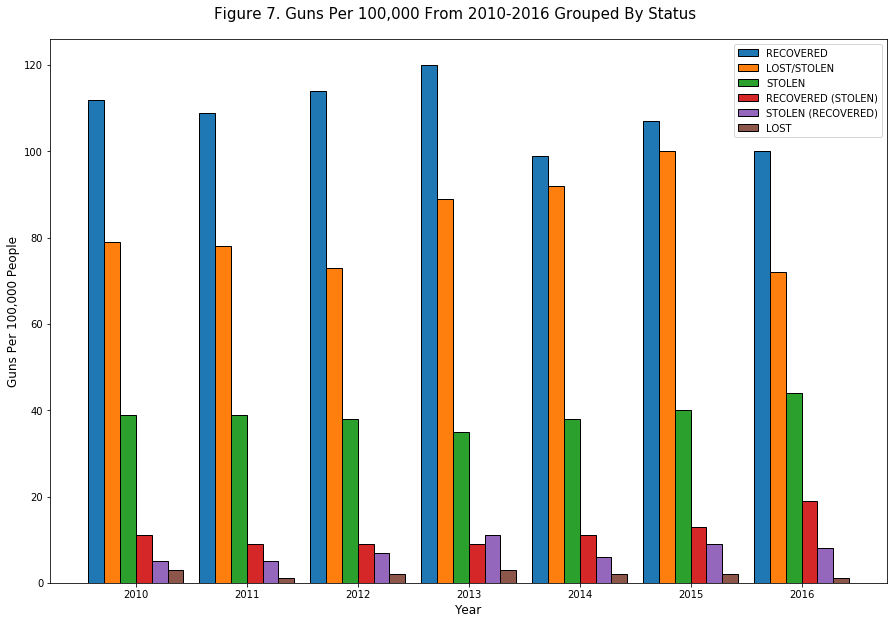

In [34]:
show_grouped_bar(year_status_per, 'Guns Per 100,000 From 2010-2016 Grouped By Status', (15,10))

Each year, guns are reported the most as recovered with a mean of 108.71428571428571 recovered guns per 100,000 people. Guns were reported lost the least with 2 guns for every 100,000 people reported solely as lost. However, in the definitions, it states that some agencies do not specify if a gun is lost or stolen, so the number of lost guns may be drastically lower here. 

## Year and State

In [35]:
year_state = pd.DataFrame()
year_state['count'] = df.groupby('year')['state'].value_counts()
year_state = year_state.reset_index()
year_state_location = df.groupby(['year', 'state', 'location']).size().reset_index().rename({0: 'count'}, axis=1)
year_state['guns per 100,000 people'] = get_guns_per2(year_state_location, year_state)
year_state = year_state.astype({'guns per 100,000 people': 'int32'})

In [36]:
year_state_per = pd.DataFrame()
year_state_per['year'] = year_state['year'].unique()
state_list = ['MD', 'MO', 'WA', 'CO', 'TX', 'CA']

for state in state_list:
    year_state_per[state] = year_state[year_state['state'] == state]['guns per 100,000 people'].to_list()

year_state_per

,year,MD,MO,WA,CO,TX,CA
0,2010,771,706,163,115,129,127
1,2011,710,681,169,106,130,123
2,2012,746,644,174,122,119,138
3,2013,715,653,232,130,118,140
4,2014,604,646,151,132,111,126
5,2015,612,829,177,172,132,123
6,2016,643,857,191,150,133,66


In [37]:
year_state_per['MD'].mean()

685.8571428571429

In [38]:
year_state_per['MO'].mean()

716.5714285714286

In [39]:
year_state_per['WA'].mean()

179.57142857142858

In [40]:
year_state_per['CA'].mean()

120.42857142857143

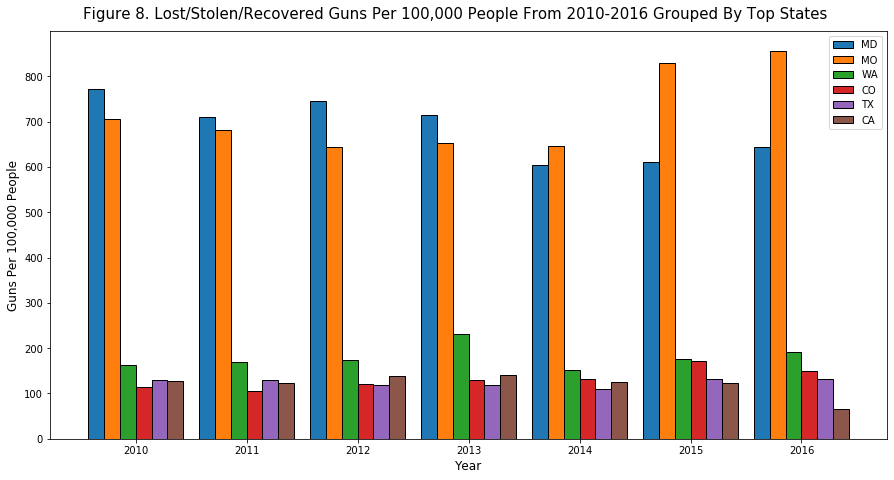

In [41]:
show_grouped_bar(year_state_per, 'Lost/Stolen/Recovered Guns Per 100,000 People From 2010-2016 Grouped By Top States', (15, 7.5))

From 2010 to 2013, Maryland had the highest number of reported guns with Maryland starting out at 771 guns per 100,000 people. However, the number of guns reported in Maryland started decreasing and the number of guns reported in Missourit significantly increased in 2015. From 2010 to 2016, Maryland reported an average of 685.8571428571429 guns per 100,000 people and Missouri had an average of 716.5714285714286 guns per 100,000. With Maryland and Missouri having the highest rates, the procceding highest guns are significantly lower than Maryland and MIssouri with the next highest state average from 2010 to 2016 being Washington at 179.57142857142858 guns per 100,000 It can be see that 2015 onward, skews the mean for Missouri. California had the lowest mean with 120.4285714285714 guns reported per 100,000 people. 

## Year and Offense

In [42]:
year_offense = pd.DataFrame()
year_offense['count'] = df.groupby('year')['offense'].value_counts()
year_offense = year_offense.reset_index()
year_offense_location = df.groupby(['year', 'offense', 'location']).size().reset_index().rename({0: 'count'})
year_offense['guns per 100,000 people'] = get_guns_per2(year_offense_location, year_offense)
year_offense = year_offense.astype({'guns per 100,000 people': 'int32'})

In [43]:
# Finds recurring offenses between years to compare
temp_list = []
for year in year_offense['year'].unique():
    temp_list.append(list(year_offense[year_offense['year'] == year]['offense'].head()))
    
recurring_offense = list(set(temp_list[0]) & set(temp_list[1]) & set(temp_list[2]) & set(temp_list[3]) & set(temp_list[4]))

In [44]:
recurring_offense = ['HANDGUN VIOLATION', 'RECOVERED FOUND PROPERTY', 'RESIDENTIAL BURGLARY', 'FOUND PROPERTY']

In [45]:
year_offense_per = pd.DataFrame()
year_offense_per['year'] = year_offense['year'].unique()
year_list = year_offense_per['year'].to_list()

for offense in recurring_offense:
    temp_list = []
    for year in year_list:
        temp_list.append(year_offense[(year_offense['offense'] == offense) & (year_offense['year'] == year)]['guns per 100,000 people'].to_list()[0])
    year_offense_per[offense] = temp_list
    
year_offense_per

,year,HANDGUN VIOLATION,RECOVERED FOUND PROPERTY,RESIDENTIAL BURGLARY,FOUND PROPERTY
0,2010,271,52,28,7
1,2011,264,51,25,13
2,2012,279,41,27,8
3,2013,272,53,25,7
4,2014,268,37,34,6
5,2015,302,42,20,8
6,2016,347,30,19,14


In [46]:
year_offense_per['HANDGUN VIOLATION'].mean()

286.14285714285717

In [47]:
year_offense_per['RECOVERED FOUND PROPERTY'].mean()

43.714285714285715

In [48]:
year_offense_per['RESIDENTIAL BURGLARY'].mean()

25.428571428571427

In [49]:
year_offense_per['FOUND PROPERTY'].mean()

9.0

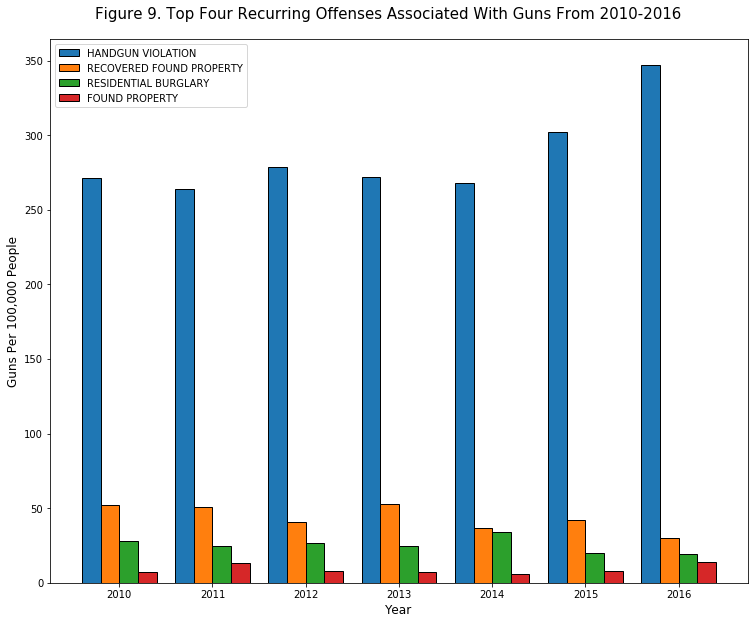

In [50]:
show_grouped_bar(year_offense_per, 'Top Four Recurring Offenses Associated With Guns From 2010-2016', (12.5, 10))

From 2010 to 2016, handgun violations had the highest rate of being reported with a mean of 286.14285714285717 per 100,000 people and the number of handgun violations was trending upwards. With the overall highest rate of offenses, it is no surprise that each year, handgun violations were the highest offense. The next highest offense had a significantly lower rate which was recovered found property at a mean of 43.714285714285715 per 100,000 people per year. The lowest of the top was found property which could probably be combined with recovered found property due to how different agencies report. 

## Year and Gun

In [51]:
year_gun = pd.DataFrame()
year_gun['count'] = df.groupby('year')['gun type'].value_counts()
year_gun = year_gun.reset_index()
year_gun_location = df.groupby(['year', 'gun type', 'location']).size().reset_index().rename({0: 'count'})
year_gun['guns per 100,000 people'] = get_guns_per2(year_gun_location, year_gun)
year_gun = year_gun.astype({'guns per 100,000 people': 'int32'})

In [52]:
year_gun_per = pd.DataFrame()
year_gun_per['year'] = year_gun['year'].unique()
gun_list = year_gun['gun type'].head(6).unique()

for gun in gun_list:
    year_gun_per[gun] = year_gun[year_gun['gun type'] == gun]['guns per 100,000 people'].to_list()

year_gun_per

,year,PISTOL,RIFLE,SHOTGUN,ALL OTHERS,RIFLE SHOTGUN COMBINATION,AMMUNITION
0,2010,81,20,24,6,3,2
1,2011,77,29,23,8,4,3
2,2012,80,19,21,8,4,4
3,2013,84,28,24,6,5,5
4,2014,72,17,19,6,3,3
5,2015,87,24,18,7,5,3
6,2016,84,14,11,6,4,3


In [53]:
year_gun_per['PISTOL'].mean()

80.71428571428571

In [54]:
year_gun_per['RIFLE'].mean()

21.571428571428573

In [55]:
year_gun_per['SHOTGUN'].mean()

20.0

In [56]:
year_gun_per['AMMUNITION'].mean()

3.2857142857142856

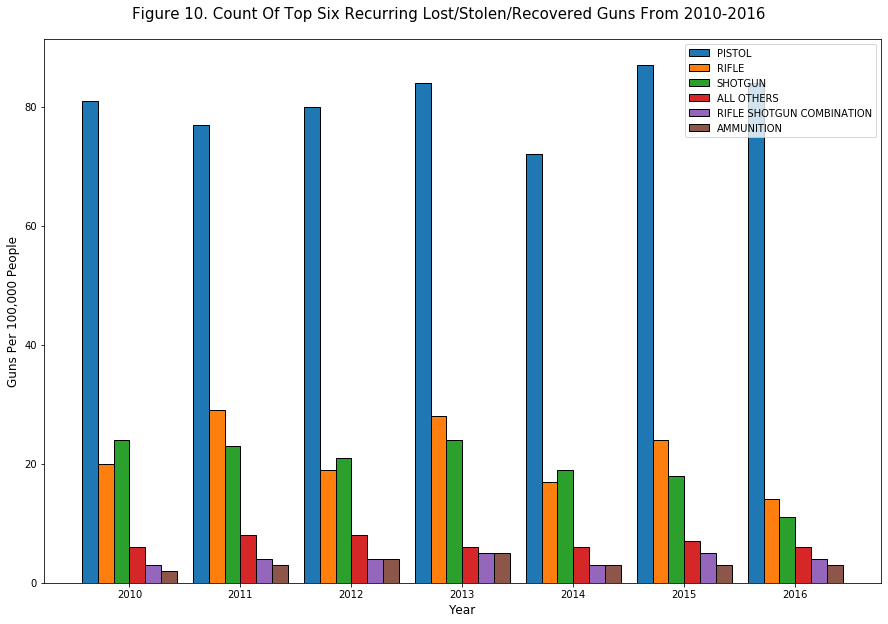

In [57]:
show_grouped_bar(year_gun_per, 'Count Of Top Six Recurring Lost/Stolen/Recovered Guns From 2010-2016', (15, 10))

Again, pistols are the have the highest rate of guns being reported with a mean of 80.71428571428571 per 100,000 people from 2010 to 2016 which coincides with the high rate of handgun violations. Rifles and shotguns were the next two guns with the highest rate at 21.571428571428573 and 20.0 guns per 100,000 people respectively. Ammunition was the lowest of the top of reported weapon with a mean of 3.2857142857142856 per 100,000 people from 2010 to 2016. 

## Gun and State

In [58]:
state_gun = pd.DataFrame()
state_gun['count'] = df.groupby('state')['gun type'].value_counts()
state_gun = state_gun.reset_index()
state_gun_location = df.groupby(['state', 'gun type', 'location']).size().reset_index().rename({0: 'count'})
state_gun['guns per 100,000 people'] = get_guns_per2(state_gun_location, state_gun)
state_gun = state_gun.astype({'guns per 100,000 people': 'int32'})

In [59]:
# finds recurring guns between top states
temp_list = []
for state in state_df['state'].head(6):
    temp_list.append(state_gun[state_gun['state'] == state]['gun type'].head().to_list())
    
recurring_guns = list(set(temp_list[0]) & set(temp_list[1]) & set(temp_list[2]) & set(temp_list[3]) & set(temp_list[4]) & set(temp_list[5]))
recurring_guns.sort()

In [60]:
state_gun_per = pd.DataFrame()
state_gun_per['state'] = state_df['state'].head(6)

for gun in recurring_guns:
    gun_state_per= []
    for state in state_df['state'].head(6):
        gun_state_per.append(list(state_gun[(state_gun['gun type'] == gun) & (state_gun['state'] == state)]['guns per 100,000 people'])[0])
    state_gun_per[gun] = gun_state_per
    
state_gun_per

,state,PISTOL,RIFLE,SHOTGUN
3,MO,4288,415,295
1,MD,3685,532,581
6,NY,1775,583,737
10,KS,759,283,187
9,AZ,816,226,130
4,WA,737,260,152


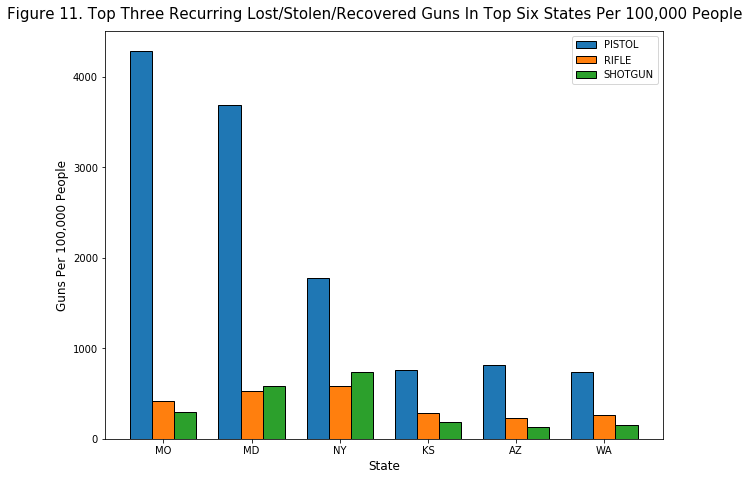

In [61]:
show_grouped_bar(state_gun_per, 'Top Three Recurring Lost/Stolen/Recovered Guns In Top Six States Per 100,000 People', (10,7.5))

When comparing the top states and the top guns, Missori has the highest number of pistols at a rate of 4288 per 100,000 people with Maryland following behind at a rate of 3685 rifles reported per 100,000 people. The it begins to signifiacntly decline with New York with a reported rate of 1765 pistols per 100,000 people. 

## Chi-Square Tests Of Homogeneity

In [62]:
def chi2_dist_plot(dof):
    dist = stats.chi2(df=dof)
    fig = plt.figure(figsize=(10,10))
    x = np.linspace(dist.ppf(0.0000000001), dist.ppf(0.9999), 100)
    plt.plot(x, dist.pdf(x))
    plt.plot([dist.ppf(0.95), dist.ppf(0.95)],[0, dist.pdf(dist.ppf(0.95))], linestyle='dotted', color='#1f77b4')
    X_fill = np.linspace(dist.ppf(0.95), dist.ppf(0.9999))
    Y = dist.pdf(X_fill)
    plt.fill_between(X_fill, 0, Y, facecolor='red')
    plt.ylim(bottom=0)
    plt.xlabel('Chi-Square Statistic')
    plt.ylabel('Probability Density Function')
    title = 'Chi-Square Distribution with {} Degrees of Freedom'.format(dof)
    fig.suptitle(title, fontsize=15, y=0.92)
    plt.show()

In [63]:
obs = []
for status in year_status_per.columns[1:]:
    obs.append(list(year_status_per[status]))
    
chi2, p, dof, ex = stats.chi2_contingency(obs)

print('Test statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected values:', ex)

Test statistic: 21.576773191082683
p-value: 0.8689908076261699
Degrees of freedom: 30
Expected values: [[107.4809983  104.02779353 104.89109472 115.25070902 107.0493477
  116.9773114  105.32274532]
 [ 82.3408962   79.69540556  80.35677822  88.29325014  82.01020987
   89.61599546  80.68746455]
 [ 38.55757232  37.31877482  37.62847419  41.3448667   38.40272263
   41.96426546  37.78332388]
 [ 11.44015882  11.07260352  11.16449234  12.26715825  11.39421441
   12.4509359   11.21043676]
 [  7.20306296   6.97163925   7.02949518   7.72376631   7.174135
    7.83947816   7.05842314]
 [  1.9773114    1.91378332   1.92966534   2.12024957   1.96937039
    2.15201361   1.93760635]]


H<sub>0</sub> = The proportions of reported guns from 2010 to 2016 are the same for all statuses

H<sub>a</sub> = The proportions of reported guns from 2010 to 2016 are different for all statuses

We accept the null hypothesis since the p-value is higher than the signifance level of 0.05

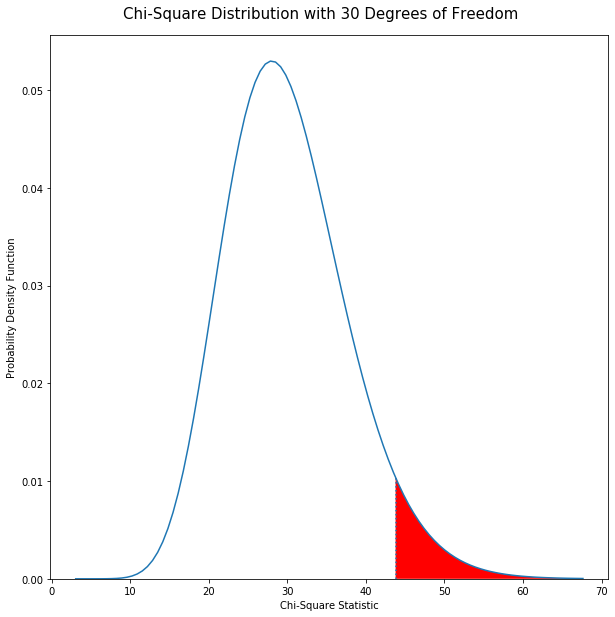

In [64]:
chi2_dist_plot(dof)

In [65]:
obs = []
for state in year_state_per.columns[1:]:
    obs.append(list(year_state_per[state]))
    
chi2, p, dof, ex = stats.chi2_contingency(obs)

print('Test statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected values:', ex)

Test statistic: 153.81348393055367
p-value: 1.4083454919058736e-18
Degrees of freedom: 30
Expected values: [[703.90864684 671.70596384 680.10666375 695.85797609 619.55161855
  715.80963838 714.05949256]
 [735.43132108 701.78652668 710.56342957 727.02012248 647.29658793
  747.86526684 746.03674541]
 [184.29768154 175.86636045 178.06583552 182.18985127 162.21128609
  187.41360455 186.95538058]
 [135.91404199 129.69619423 131.31824147 134.35958005 119.62598425
  138.21194226 137.87401575]
 [127.85010207 122.00116652 123.52697579 126.38786818 112.52843395
  130.01166521 129.69378828]
 [123.59820647 117.94378828 119.41885389 122.18460192 108.78608924
  125.68788276 125.38057743]]


H<sub>0</sub> = The proportions of reported guns from 2010 to 2016 are the same for the top six states

H<sub>a</sub> = The proportions of reported guns from 2010 to 2016 are different for the top six states

We reject the null hypothesis since the p-value is below the significance level of 0.05

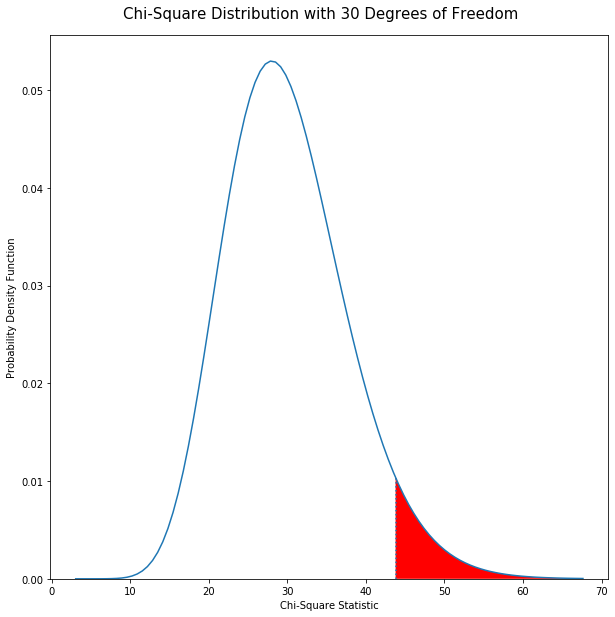

In [66]:
chi2_dist_plot(dof)

In [67]:
chi2, p, dof, ex = stats.chi2_contingency([list(year_state_per['MD']), list(year_state_per['MO'])])

print('Test statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected values:', ex)

Test statistic: 73.70651504320581
p-value: 7.084564030605049e-14
Degrees of freedom: 6
Expected values: [[722.32627075 680.26800448 679.77895487 669.0198635  611.31200978
  704.72048487 733.57441173]
 [754.67372925 710.73199552 710.22104513 698.9801365  638.68799022
  736.27951513 766.42558827]]


H<sub>0</sub> = The proportions of reported guns from 2010 to 2016 are the same for MD and MO

H<sub>a</sub> = The proportions of reported guns from 2010 to 2016 are different for MD and MO

We reject the null hypothesis since the p-value is lower than the significance level of 0.05

In [68]:
chi2, p, dof, ex = stats.chi2_contingency([list(year_state_per['CO']), list(year_state_per['TX'])])

print('Test statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected values:', ex)

Test statistic: 10.289247777107002
p-value: 0.11298783791020817
Degrees of freedom: 6
Expected values: [[125.72984992 121.60755976 124.18399111 127.790995   125.21456365
  156.64702613 145.82601445]
 [118.27015008 114.39244024 116.81600889 120.209005   117.78543635
  147.35297387 137.17398555]]


H<sub>0</sub> = The proportions of reported guns from 2010 to 2016 are the same for CO and TX

H<sub>a</sub> = The proportions of reported guns from 2010 to 2016 are different for CO and TX

We accept the null hypothesis since the p-value is higher than the significance level of 0.05

In [69]:
chi2, p, dof, ex = stats.chi2_contingency([list(year_state_per['TX']), list(year_state_per['CA'])])

print('Test statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected values:', ex)

Test statistic: 26.832035451310134
p-value: 0.00015568360785323427
Degrees of freedom: 6
Expected values: [[130.16443149 128.63906706 130.6728863  131.18134111 120.50379009
  129.65597668 101.18250729]
 [125.83556851 124.36093294 126.3271137  126.81865889 116.49620991
  125.34402332  97.81749271]]


H<sub>0</sub> = The proportions of reported guns from 2010 to 2016 are the same for TX and CA

H<sub>a</sub> = The proportions of reported guns from 2010 to 2016 are different for TX and CA

We reject the null hypothesis since the p-value is lower than the significance level of 0.05

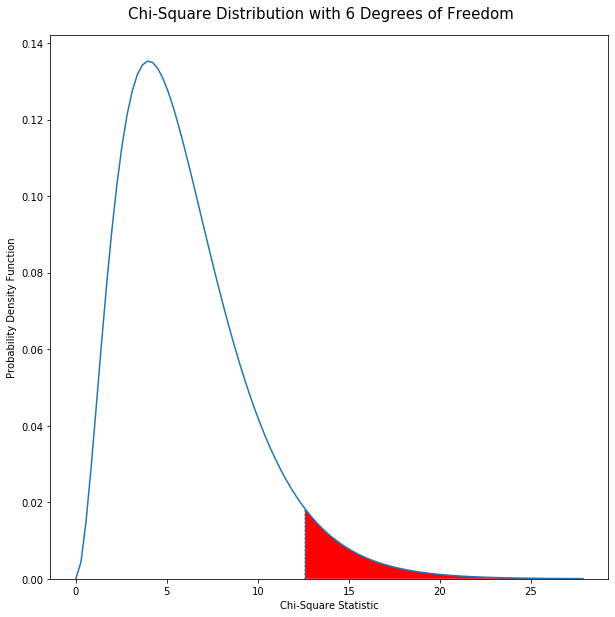

In [70]:
chi2_dist_plot(dof)

In [71]:
obs = []
for offense in year_offense_per.columns[1:]:
    obs.append(list(year_offense_per[offense]))

chi2, p, dof, ex = stats.chi2_contingency(obs)

print('Test statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected values:', ex)

Test statistic: 32.36755554069049
p-value: 0.019882768953922575
Degrees of freedom: 18
Expected values: [[281.2054902  277.27803922 278.84901961 280.42       270.99411765
  292.20235294 322.05098039]
 [ 42.96        42.36        42.6         42.84        41.4
   44.64        49.2       ]
 [ 24.98980392  24.64078431  24.78039216  24.92        24.08235294
   25.96705882  28.61960784]
 [  8.84470588   8.72117647   8.77058824   8.82         8.52352941
    9.19058824  10.12941176]]


H<sub>0</sub> = The proportions of reported guns from 2010 to 2016 are the same for the top four recurring offenses

H<sub>a</sub> = The proportions of reported guns from 2010 to 2016 are different for the top four recurring offenses

We reject the null hypothesis since the p-value is lower than the significance level of 0.05

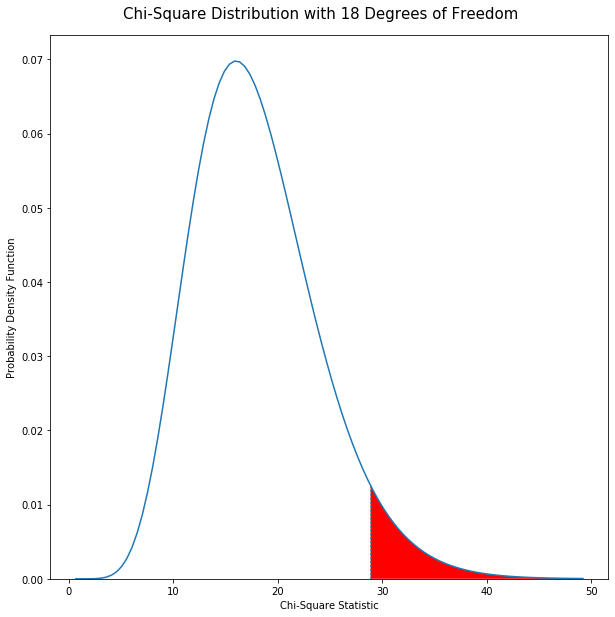

In [72]:
chi2_dist_plot(dof)

In [73]:
obs = []
for gun in year_gun_per.columns[1:]:
    obs.append(list(year_gun_per[gun]))

chi2, p, dof, ex = stats.chi2_contingency(obs)

print('Test statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected values:', ex)

Test statistic: 14.655329238361515
p-value: 0.9915470182571325
Degrees of freedom: 30
Expected values: [[80.54507338 85.28301887 80.54507338 90.02096436 71.06918239 85.28301887
  72.25366876]
 [21.52620545 22.79245283 21.52620545 24.05870021 18.99371069 22.79245283
  19.31027254]
 [19.95807128 21.13207547 19.95807128 22.30607966 17.61006289 21.13207547
  17.90356394]
 [ 6.70020964  7.09433962  6.70020964  7.4884696   5.91194969  7.09433962
   6.01048218]
 [ 3.99161426  4.22641509  3.99161426  4.46121593  3.52201258  4.22641509
   3.58071279]
 [ 3.278826    3.47169811  3.278826    3.66457023  2.89308176  3.47169811
   2.94129979]]


H<sub>0</sub> = The proportions of reported guns from 2010 to 2016 are the same for the top six guns

H<sub>a</sub> = The proportions of reported guns from 2010 to 2016 are different for the top six guns

We accept the null hypothesis since the p-value is higher than the significance level of 0.05

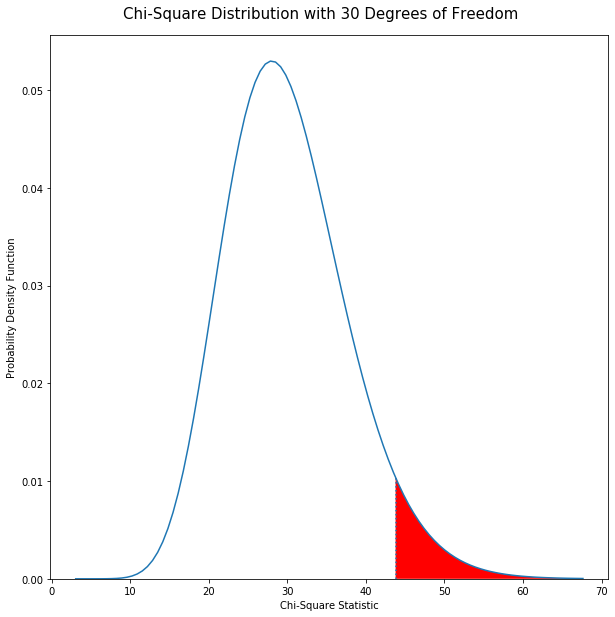

In [74]:
chi2_dist_plot(dof)

In [81]:
chi2, p, dof, ex = stats.chi2_contingency([list(state_gun_per['PISTOL']), list(state_gun_per['RIFLE']), list(state_gun_per['SHOTGUN'])])

print('Test statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected values:', ex)

Test statistic: 1106.6660221068616
p-value: 1.92933157189664e-231
Degrees of freedom: 10
Expected values: [[3666.19305395 3519.48664923 2270.28161304  901.510857    859.69953166
   842.82829512]
 [ 698.88705067  670.92038197  432.78419804  171.85517913  163.88467855
   160.66851165]
 [ 632.91989538  607.5929688   391.93418892  155.63396387  148.41578979
   145.50319324]]


H<sub>0</sub> = The proportions of guns reported in the top six states are the same for pistols, rifles, and shotguns

H<sub>a</sub> = The proportions of guns reported in the top six states are different for pistols, rifles, and shotguns

We reject the null hypothesis since the p-value is lower than the significance level of 0.05

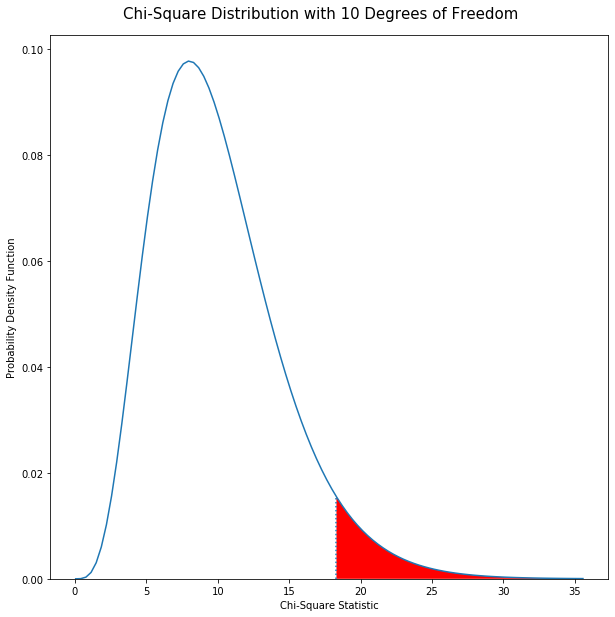

In [82]:
chi2_dist_plot(dof)

# Conclusion

Among the guns reported, pistols always had the highest rate of guns reported per 100,000 people from 2010 to 2016 among the top stats. And due to the high number of pistols, handgun violations were also one of the most recurring offenses that was observed from 2010 to 2016 among the top states. Luckily, the guns most of time were recovered by law enfocement from 2010 to 2016 among the top states. Missouri and Maryland were the top states from 2010 to 2016. 